# Social Computing - Summer 2017

# Exercise 6 - Fraud detection in the social capital market

Last week you learned that each transaction leads to an increase of the receiver's social capital weight.<p>
This week you will try to identify fraudulent behavior within the system. For this you will leverage some of the techniques that you learned in the previous exercise sheets. <p>
The fraud detection will work along the following steps:

### Steps
1) Identify the highest SCWs in the market depending on the topics<p>
2) Identify the most frequent transaction pairs (user ids) in the market<p>
3) Look at the friends/follower relationships on the social networking platform of the people with the highest SCW<p>
4) Compare the activity of the identified people on the social networking platform<p>

By following these steps you can identify users who have a high social capital weight, but no support/contributions on the social networking platform. Therefore it is likely that they tried to cheat the system.



In [1]:
#Compile this field first!
import pandas as pd
import numpy as np
from igraph import *
df = pd.read_csv('paymenttable_6.csv', sep=',')
elggexcell = pd.read_excel(open('FeatureTableDisguised.xlsx','rb'), sheetname='Sheet1')
g = Graph.Read_GraphML('FriendshipNetwork.graphml')

### Voluntary: Introduction
Import your "density" function here and compile the code. Are there any changes compared to last week?<p>
We expect people who push their SCW to have only a few transaction partners, so they would have a ratio of close to 100%. As there are many users with such high ratios the density is not sufficient to determine fraudulent behavior.

In [2]:
from __future__ import division
# df
# the result table:
columns = ['Receiver ID', 'Topic ID', 'Transactions with main partner','Number of transactions total','Percentage']

all_partner = df[(df["Transfer Value"] > 0) & (df["Sender ID"] != df["Receiver ID"]) ].groupby(["Sender ID","Receiver ID","Topic ID"]).count()['Transfer ID'].reset_index()
main_partner = all_partner.groupby(["Receiver ID","Topic ID"],sort =  False)["Transfer ID"].max().reset_index()
total_transactions = df[(df["Transfer Value"] > 0) & (df["Sender ID"] != df["Receiver ID"]) ].groupby(["Receiver ID","Topic ID"]).count()['Transfer ID'].reset_index()
merged = pd.merge(main_partner,total_transactions , on=["Topic ID","Receiver ID"])
merged['Percentage'] = (merged['Transfer ID_x']/merged['Transfer ID_y']*100)
merged.columns = columns
table = merged.sort_values(['Percentage'],ascending = [True])[['Receiver ID','Topic ID','Number of transactions total', 'Transactions with main partner','Percentage']]
table

,Receiver ID,Topic ID,Number of transactions total,Transactions with main partner,Percentage
37,35,6,16,1,6.250000
27,72,6,19,2,10.526316
34,242,5,7,1,14.285714
61,110,2,7,1,14.285714
57,72,4,6,1,16.666667
23,111,6,6,1,16.666667
44,29,2,5,1,20.000000
129,190,2,5,1,20.000000
29,1,6,5,1,20.000000
92,46,6,5,1,20.000000


# Problem 1: Step 1 - Identification of user's with high SCW
Identify the highest SCWs in the market depending on the topics!<p>
The result should be a table with the topic ID, the SCW new of the receiver, and the receiver ID.<p>
Hint: Make sure that the transfer value is larger than 0 and that receiver ID and sender ID are not the same.

In [3]:
# For each topic (1 to 6), identify the user (Receiver ID) with the highest SCW in the market
df[(df["Transfer Value"] > 0) & (df["Sender ID"] != df["Receiver ID"])][["Receiver ID","SCW new of receiver","Topic ID"]]\
.sort_values("SCW new of receiver",ascending=False).groupby(["Topic ID"]).first()

,Receiver ID,SCW new of receiver
Topic ID,,
1,217,1.645000
2,97,21.550537
3,47,1.830000
4,242,4.892450
5,242,3.968922
6,242,5.927137


Who is the person with the highest social capital weight (regardless of category)?

Receiver ID 97 is the user with the highest social capital weight.

# Problem 2: Step 2 - identification of the main transaction partners
Identify the most frequent transaction pairs in the market system. Therefore, create a table that shows the IDs of the two users and number of transactions between them. Display the top three transaction pairs in each topic. 

Is there an overlap between the results from step 1? E.g., are the users with high social capital also in the new list?

In [4]:
new  = df[(df["Sender ID"] != df["Receiver ID"]) ][["Topic ID","Sender ID","Receiver ID","Transfer ID"]].groupby(["Topic ID","Sender ID","Receiver ID"]).count().reset_index().sort_values(["Transfer ID"], ascending=False)
new.columns = ["Topic ID","Sender ID","Receiver ID","Transfer_ID"]
# generate a list of ID pairs, where we don't care about the order
pairs = [str(sorted([a,b])) for a,b in zip(new['Receiver ID'], new['Sender ID'])]
# note that you have to convert the sorted list to a string, otherwise drop_duplicates won't work...
new['Partner_IDs'] = pairs
noduplicates = new.drop(['Receiver ID', 'Sender ID'], axis=1).drop_duplicates()

new_frame = noduplicates.groupby(['Topic ID']).head(3).sort_values("Topic ID",ascending=True)

new_frame = pd.concat([new_frame,new_frame['Partner_IDs'].apply(lambda x:pd.Series(str(x[1:-1]).split(',')))],1)

new_frame.columns = ["Topic ID","Count","Partner_IDs","User1","User2"]
freq_trans = new_frame[["Topic ID","User1","User2","Count"]]
freq_trans

,Topic ID,User1,User2,Count
20,1,45,46,2
71,1,217,218,3
0,1,1,92,3
158,2,96,97,12
220,2,118,123,4
143,2,72,123,3
386,3,136,140,2
356,3,102,103,2
371,3,116,118,2
475,4,69,70,4


8,Is the user with the highest social capital weight (as identified in step 1) also present in this table? 
If so, who is her/his main transaction partner?

Yes , user with the ID 97 is present in the table with the count of 12 transactions.

# Problem 3: Step 3 - Compare the results to the relationship graph

In step 1 and 2 you identified the users with the highest social capital weight and the main transaction partners in the market system. Now we want to verify if their high social capital weight is deserved (because of many good interactions on the social networking platform) or if it should be flagged as fraudulent. <p>

At first we want to look at the friends/follower network surounding the identified pairs. <b> Plot a subgraph of the FriendshipNetwork.graphml that displays the relationship between the user with the highest social capital weight and the main transaction partner, as well as all their neighboring nodes (connected via a friend/follower relationship). </b>

<b>Compare this network to some of the other transaction pairs identified in step 2. What do you notice? (1-2 sentences) </b> 

If you get the error "ValueError: no such vertex: '218'" don't worry and just try another pair. This is due to the fact that sometimes we still don't have a correct matching between the social networking platform and the market system. Spoiler: this person is not the cheater that we planted.

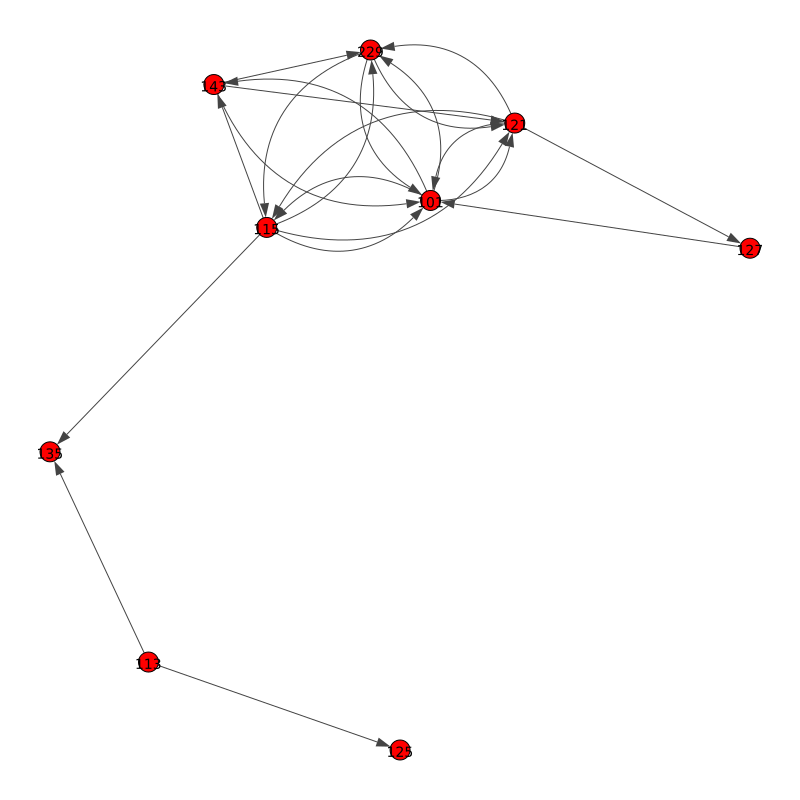

In [5]:
import igraph as ig
g = ig.Graph.Read_GraphML("FriendshipNetwork.graphml")
visual_style = {}
visual_style["vertex_label"] = g.vs["name"]
visual_style["bbox"] = (800, 800)
visual_style["margin"] = 50
g2=g.subgraph([96,97]+(g.neighbors(96))+(g.neighbors(97)),"create_from_scratch")
ig.plot(g2, **visual_style)

#your answer here
User with id 97 has a very few connections(freiends and followers) as compared to user 92(and user 1)

# Problem 4: Step 4 - Compare the results to the interaction patterns

Now we want to have a closer look at the interactions of the user with the highest social capital weight on the social networking platform. <b>Using the table "FeatureTableDisguised.xlsx" display this user's number of posts (Posts), number of comments (Comments), the likes received on posts (Likes_OnPosts) and comments (Likes_OnComments), as well as the number of friends (Friends) and followers (Followers).</b> <p>
Compare this to some of the other users with high social capital. (1-3 sentences)

In [6]:
#your code here
elggexcell = pd.read_excel(open('FeatureTableDisguised.xlsx','rb'), sheetname='Sheet1')
elggexcell[(elggexcell["User ID"] ==97) | (elggexcell["User ID"] ==96)]

,User ID,Posts,Comments,Likes_OnPosts,Likes_OnComments,Friends,Followers,Comments recOnPosts,ToCHARposts,ToCHARcomments
91,96,0,0,0,0,0,0,0,0,0
92,97,0,0,0,0,0,0,0,0,0



For User ID 97, number of posts (Posts), number of comments (Comments), the likes received on posts (Likes_OnPosts)
and comments (Likes_OnComments), as well as the number of friends (Friends) and followers (Followers) is 0.



# Voluntary: Problem 5 - Summary
You identified a pair of users with a abnormally high social capital weight and had a look at their interactions in the social network.

How did they manage to artificially inflate their social capital weight? (1-3 sentences)



What can be done to prevent it? (3-5 sentences)



1. The user may create two accounts (eg  user 96 and 97 ) and inflated their social capital weights 

2. We could make sure that every user is mapped to one account and if the User ID is different but the Posts, Comments, likes and comments is zero or their main transaction partners is a single user_id whith the same features, we could identify that user as fraudelant.